                                                      EU ETS Emissions vs Carbon Price:
                                               Did Higher EUA Prices Drive Emissions Reductions?

**Author:** Assmaa Fouqade

**Date:** February 2026

**Purpose:** Analyze whether rising carbon prices under the EU ETS are associated with emissions reductions across sectors and over time.

# Introduction

This notebook examines emissions under the EU Emissions Trading System (EU ETS) across covered sectors, alongside developments in EUA prices, from the inception of the system in 2005, through 2023.



# Executive summary

The analysis shows that EU ETS emissions declined substantially over the study period—driven primarily by reductions in the power sector—while sustained increases in EUA prices occurred only in later years, indicating no clear contemporaneous relationship between carbon prices and emissions reductions over the full period,  however, a much clearer relationship emerges between emissions reductions and the extent of auctioned allowances, highlighting the role of credible carbon price exposure in driving sectoral decarbonisation.



# Data and Methodology

**Data sources**

  - EU ETS emissions : european environmental agency (EEA) (dataset code: European Union Emissions Trading System (EU ETS) data from the Union Registry)

  - EUA prices: From 2005 to 2008 : ICAP,From 2009 to 2023 : European Central Bank ( dataset code : Capital markets-Carbon price-EU allowance per metric ton - Winter/March 2024, Euro area, Annual).

**Coverage**

- Sectors : Power, Industry, Aviation and other minor sources

- Geopolitical entity : EU + UK + other EU countries

- Time period : 2005 - 2023

- Frequency : Annual

**Units**

  - GHG Emissions: tonnes of CO₂equivalent

  - EUA price: euro

**Data format**

CSV files

**Methodology**
 - Import datasets

 - Inspect and clean datasets

 - Merge EUA prices data with EU ETS emissions data

 - Generate summary table

 - Visuals


**Import libraries**

In [1]:
# Import needed libraries

import pandas as pd
import matplotlib.pyplot as plt

# EU ETS emissions data preparation

**Import EU ETS emissions data**

In [2]:
# Import EU ETS emissions dataset
df_emissions = pd.read_csv('/Users/asmaafouqade/Desktop/ETS_emissions.csv', sep=';')

# Show data values
display(df_emissions.head().to_string())

# Check shape
display(df_emissions.shape)

# Show columns
display(df_emissions.columns)

# Describe data
df_emissions.info()

'    Country Code  Year   Value               Unit                                             subsectors\n0  All Countries  2005       0              units                     20-99 All stationary installations\n1  All Countries  2005   40778              units  34 Production or processing of gypsum or plasterboard\n2  All Countries  2005   40778              units  34 Production or processing of gypsum or plasterboard\n3  All Countries  2005   45592  tonne of CO2 equ.  34 Production or processing of gypsum or plasterboard\n4  All Countries  2005  287314              units                           38 Production of nitric acid'

(97269, 5)

Index(['Country Code', 'Year', 'Value', 'Unit', 'subsectors'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97269 entries, 0 to 97268
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Country Code  97269 non-null  object
 1   Year          97269 non-null  object
 2   Value         97231 non-null  object
 3   Unit          97269 non-null  object
 4   subsectors    97269 non-null  object
dtypes: object(5)
memory usage: 3.7+ MB


sep = ';' added to correctly structure the data into columns as the CSV file used a semicolon as a delimiter instead of a comma.

**Country data inspection and filtering**

In [3]:
# Check unique values for Country Code
country_code = df_emissions["Country Code"].unique()
display(country_code)

# Keep only All Countries
df_emissions = df_emissions[df_emissions["Country Code"].isin(["All Countries"])]

array(['All Countries', 'AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE',
       'ES', 'EU27', 'EU27 + UK', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU',
       'IE', 'IS', 'IT', 'LI', 'LT', 'LU', 'LV', 'MT', 'NL', 'NO', 'PL',
       'PT', 'RO', 'RRF', 'SE', 'SI', 'SK', 'XI'], dtype=object)

All countries were included to account for the UK’s EU membership until 2020, which is essential for consistency given that the analysis period begins in 2005 rather than using the EU-27 membership.

**Year data inspection and filtering**

In [4]:
# Check Year unique values
display(df_emissions["Year"].unique())

# Filter years to keep only 2005-2023
df_emissions = df_emissions[df_emissions["Year"].between("2005","2023")]

# Convert Year values to integer
df_emissions["Year"] = df_emissions["Year"].astype(int)

array(['2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020',
       '2021', '2022', '2023', '2024', '2025',
       'Total 1st trading period (05-07)',
       'Total 2nd trading period (08-12)',
       'Total 3rd trading period (13-20)',
       'Total 4th trading period (21-30)'], dtype=object)

**Unit data inspection and filtering**

In [5]:
# Check unit values
display(df_emissions["Unit"].value_counts())

# Drop unit column
df_emissions = df_emissions.drop(columns = "Unit")

Unit
units                3051
tonne of CO2 equ.    1084
Name: count, dtype: int64

Dropped unit column and consider unit as tCO2eq as it is on the EEA website.

**Emissions data inspection and filtering**

In [6]:
# Check subsectors unique
print(df_emissions["subsectors"].unique())
print(df_emissions["subsectors"].value_counts())

# Create map for subsectors to join them into one sector
sector_map = {
    # Power subsectors
    '20-99 All stationary installations': 'Power',
    '20 Combustion of fuels': 'Power',
    # Aviation sector
    '10 Aviation': 'Aviation',
    # Other minor subsectors
    '99 Other activity opted-in under Art. 24': 'Other',
    '45 Capture of greenhouse gases under Directive 2009/31/EC': 'Other',

    # Industry subsectors
    '34 Production or processing of gypsum or plasterboard': 'Industry',
    '38 Production of nitric acid': 'Industry',
    '26 Production of primary aluminium': 'Industry',
    '37 Production of carbon black': 'Industry',
    '28 Production or processing of non-ferrous metals': 'Industry',
    '44 Production of soda ash and sodium bicarbonate': 'Industry',
    '43 Production of hydrogen and synthesis gas': 'Industry',
    '41 Production of ammonia': 'Industry',
    '35 Production of pulp': 'Industry',
    '31 Manufacture of glass': 'Industry',
    '22  Production of coke': 'Industry',
    '36 Production of paper or cardboard': 'Industry',
    '21  Refining of mineral oil': 'Industry',
    '29 Production of cement clinker': 'Industry',
    '24  Production of pig iron or steel': 'Industry',
    '21-99 All industrial installations (excl. combustion)': 'Industry',
    '27 Production of secondary aluminium': 'Industry',
    '23 Metal ore roasting or sintering': 'Industry',
    '33 Manufacture of mineral wool': 'Industry',
    '25 Production or processing of ferrous metals': 'Industry',
    '42 Production of bulk chemicals': 'Industry',
    '32 Manufacture of ceramics': 'Industry',
    '30 Production of lime, or calcination of dolomite/magnesite': 'Industry',
    '39 Production of adipic acid': 'Industry',
    '40 Production of glyoxal and glyoxylic acid': 'Industry'
}


# Apply the map
df_emissions["Sector"] = df_emissions["subsectors"].map(sector_map)

# Drop subsectors column
df_emissions =df_emissions.drop(columns = "subsectors")

# Merge Sectors by sector
df_emissions = df_emissions.sort_values(["Year","Sector"])

# Replace "," with "." to make it readable by python
df_emissions['Value'] = df_emissions['Value'].str.replace(',', '.')

# Convert string Value column values to float
df_emissions["Value"] = df_emissions["Value"].astype(float)

# Create a new dataframe to store aggregated values because : Cannot set a DataFrame with multiple columns to the single column emissions
df_agg= df_emissions.groupby(["Year","Sector"])["Value"].sum().reset_index().fillna(False)

# Rename Value column for convinience
df_agg = df_agg.rename(columns = {"Value": "Emissions"})
df_agg.head()

['20-99 All stationary installations'
 '34 Production or processing of gypsum or plasterboard'
 '38 Production of nitric acid' '26 Production of primary aluminium'
 '37 Production of carbon black'
 '28 Production or processing of non-ferrous metals'
 '44 Production of soda ash and sodium bicarbonate'
 '43 Production of hydrogen and synthesis gas' '41 Production of ammonia'
 '35 Production of pulp' '31 Manufacture of glass'
 '22  Production of coke' '36 Production of paper or cardboard'
 '21  Refining of mineral oil' '29 Production of cement clinker'
 '24  Production of pig iron or steel'
 '21-99 All industrial installations (excl. combustion)'
 '20 Combustion of fuels' '27 Production of secondary aluminium'
 '23 Metal ore roasting or sintering' '10 Aviation'
 '99 Other activity opted-in under Art. 24'
 '33 Manufacture of mineral wool'
 '25 Production or processing of ferrous metals'
 '42 Production of bulk chemicals' '32 Manufacture of ceramics'
 '30 Production of lime, or calcination 

,Year,Sector,Emissions
0,2005,Aviation,0.000000e+00
1,2005,Industry,6.892764e+09
2,2005,Other,4.233309e+06
3,2005,Power,2.077937e+10
4,2006,Aviation,0.000000e+00


# EU allowances data preparation

**Import EUA data**

In [7]:
# Import EUA data
df_prices = pd.read_csv('/Users/asmaafouqade/Desktop/Allowances prices.csv', sep=";",usecols=[0,1])
df_prices

,year,price
0,2005,21.0
1,2006,7.5
2,2007,0.0
3,2008,16.0
4,2009,13.0
5,2010,14.3
6,2011,13.0
7,2012,7.4
8,2013,4.5
9,2014,6.0


sep=';' tells pandas to split columns by ;
usecols=[0,1] ignores the extra empty column caused by the trailing ;;

In [8]:
# Rename columns for convinience
df_prices = df_prices.rename(columns = {"year":"Year", "price": "EUA"})

# Merging EUA prices data to EU ETS emissions data

In [9]:
# Merging df_agg and df_prices
new_df = df_agg.merge(df_prices, on = "Year", how = "left")
new_df.head()

,Year,Sector,Emissions,EUA
0,2005,Aviation,0.000000e+00,21.0
1,2005,Industry,6.892764e+09,21.0
2,2005,Other,4.233309e+06,21.0
3,2005,Power,2.077937e+10,21.0
4,2006,Aviation,0.000000e+00,7.5


# Visuals

**Plot EU ETS emissions trends vs EUA prices**

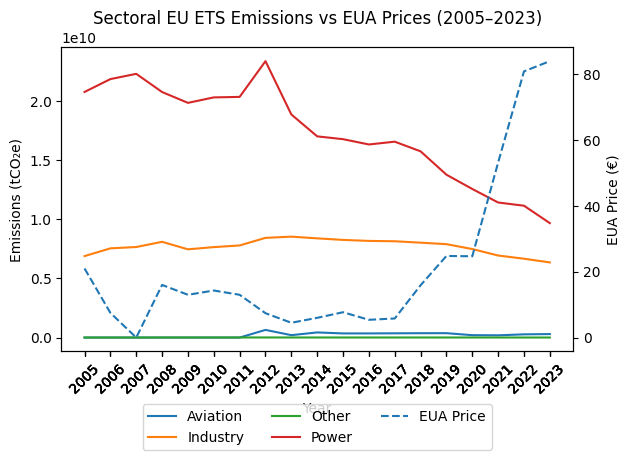

In [10]:
# Plot for dual axis plot sector emissions vs prices

# Initialize figure and primary axis
fig, ax1 = plt.subplots()

# Plot EU ETS emissions (left axis)
for Sector in new_df["Sector"].unique():
    data = new_df[new_df["Sector"] == Sector]
    ax1.plot(data['Year'], data["Emissions"], label=Sector)

# Label EU ETS emissions axes and title
ax1.set_xlabel("Year")
ax1.set_ylabel("Emissions (tCO₂e)")
ax1.set_title("Sectoral EU ETS Emissions vs EUA Prices (2005–2023)")



# Create a second axis for EUA price
ax2 = ax1.twinx()

# Plot EUA prices
ax2.plot(new_df['Year'], new_df['EUA'], linestyle='--', label='EUA Price')
# Label the EUA axis
ax2.set_ylabel("EUA Price (€)")


# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

# Show all years
years = new_df['Year']
ax1.set_xticks(years)
ax1.set_xticklabels(years, rotation=45)

ax1.legend(
    lines_1 + lines_2,
    labels_1 + labels_2,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=3
)

plt.tight_layout()
# Show plot
plt.show()

The plot illustrates sectoral EU ETS emissions trends alongside EUA price developments over the study period.

The power and industry sectors account for the highest emission levels throughout the period, whereas aviation and other minor sectors contribute relatively low or near-zero emissions.

Emissions from the power sector, the largest emitting sector, show a pronounced decline over time, falling by nearly half—from over 2.1 × 10¹⁰ tCO₂e in 2005 to below 1.1 × 10¹⁰ tCO₂e in 2023.
The industry sector exhibits fluctuations over the period; however, emissions at the end of the study period remain broadly comparable to those observed at the beginning (approximately 0.6 × 10¹⁰ tCO₂e).

Aviation emissions appear from 2012 onwards and remain relatively low through to 2023.
Emissions from other minor sectors are negligible and remain close to zero throughout the period.

EUA prices display substantial volatility between 2005 and 2019, ranging from near zero to around €20–21. From 2020 onward, EUA prices increase sharply, reaching over €80 in 2023, indicating a significant strengthening of the EU carbon price signal in recent years.



**Plot EU ETS emissions change VS EUA prices**

**Compute year-to-year emissions change**

In [11]:
# Sort values to ensure correct year-to-year calculation
new_df = new_df.sort_values(["Sector", "Year"])

# Compute year-to-year emissions change
new_df["emissions_change"] = new_df.groupby("Sector")["Emissions"].diff()
new_df
new_df.to_csv("dataEUA.csv")

**Plot EU ETS emissions change vs EUA prices**

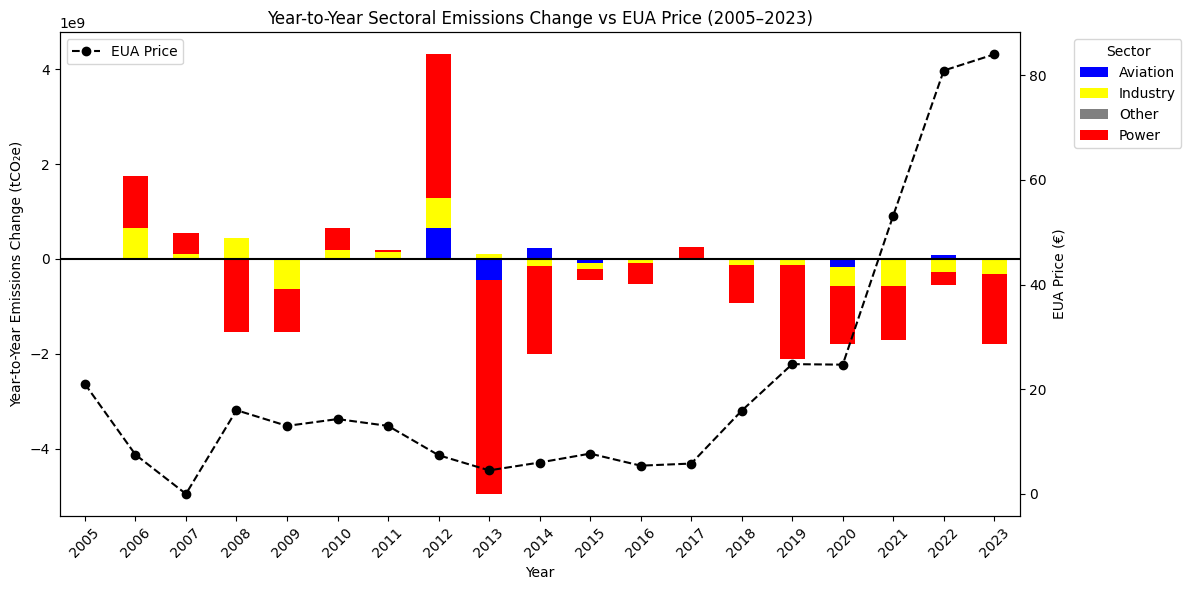

In [12]:

# Reshape data to wide-format so it's stacked bar chart friendly
stacked_data = (new_df.pivot_table(
    index="Year", # each year will be one year
    columns="Sector",  # each column will be a sector
    values="emissions_change", # values
    aggfunc="sum") # If a year has multiple entries for the same sector, sum them
    .fillna(0))

# Create the figure and main axis
fig, ax1 = plt.subplots(figsize=(12,6))

# Stacked bars colors
colors = {"Industry":"Yellow", "Power":"Red", "Aviation":"Blue", "Other":"grey"}

# Plot stacked bars
stacked_data.plot(
    kind="bar",
    stacked=True,
    ax=ax1,       # Plot on the left axis
    color=colors)

# Label axes and title
ax1.set_xlabel("Year")
ax1.set_ylabel("Year-to-Year Emissions Change (tCO₂e)")
ax1.set_title("Year-to-Year Sectoral Emissions Change vs EUA Price (2005–2023)")

# Add zero reference line
ax1.axhline(0, color = "black")

# Prepare EUA prices data
eua_prices = new_df[["Year","EUA"]].drop_duplicates()

# Create secondary axis: EUA price
ax2 = ax1.twinx()

# Plot EUA prices (dashed line)
bar_positions = range(len(stacked_data.index)) # Ensures the line aligns with the bar centers
ax2.plot(
    bar_positions,
    eua_prices["EUA"].values,
    color='black',
    linestyle='--',
    marker='o',
    label='EUA Price')


# Secondary axis labeling
ax2.set_ylabel("EUA Price (€)")
ax2.legend(loc='upper left')

# X-ticks
ax1.set_xticks(bar_positions)                        # Ensures years align with bars
ax1.set_xticklabels(stacked_data.index, rotation=45) # Rotation prevents overlapping labels

# Legend for sectors (fixed: convert Index to list)
handles, _ = ax1.get_legend_handles_labels()
ax1.legend(handles=handles, labels=list(stacked_data.columns), # Uses actual bar handles
           title="Sector", bbox_to_anchor=(1.05, 1), loc='upper left') # Guarantees legend colors match bars , Places legend outside the plot for clarity

# To avoid years overlapping
plt.tight_layout()

# Show plot
plt.show()

At first glance, the main contributing sectors are power and industry, with decreases outweighing increases over the period. Year-to-year emissions changes vary considerably across sectors and time. Between 2005 and 2012, emissions changes are predominantly positive, particularly in the power sector, which exhibits a pronounced increase in 2012. From 2013 onward, emissions decline sharply across all sectors, with the largest reductions observed in power generation.

Over the same period, EUA prices display substantial volatility, remaining low and occasionally near zero between 2005 and 2019, before increasing sharply after 2020 and reaching over €80 in 2023.The major emission reductions precede the sustained rise in EUA prices, suggesting no clear contemporaneous correlation between price levels and emissions changes over the full period, However, the sectoral patterns observed point to a meaningful relationship between emissions outcomes and credible exposure to carbon pricing over time. Sectors fully exposed to the EU ETS carbon price, most notably power generation, experienced the largest and most sustained emissions reductions, while sectors shielded through free allocation or limited coverage, such as industry and aviation, showed weaker responses. This divergence suggests that emissions reductions are more closely linked to the effective and unavoidable cost of carbon—shaped by allocation rules, coverage, and expectations of future scarcity—than to headline EUA price levels alone.

This temporal disconnect suggests that early emission reductions were likely driven by factors other than carbon prices, such as economic conditions, fuel switching, or regulatory measures, while the impact of higher carbon prices may only emerge in the later years.


# Summary

- Power and industry are the dominant emitting sectors throughout, while aviation and other minor sectors contribute relatively low or near-zero emissions.

- Emissions decline is driven primarily by the power sector, whose emissions fall by nearly half between 2005 and 2023, whereas industry emissions fluctuate but remain broadly stable over the period.

- Year-to-year emissions changes are mostly positive between 2005 and 2012, particularly in the power sector, followed by sharp and sustained declines from 2013 onward across all sectors.

- EUA prices remain low and volatile until 2019 and increase sharply only after 2020, meaning that the main emission reductions precede the sustained price increase. This suggests no clear contemporaneous correlation between emissions changes and EUA price levels.Instead, a much clearer relationship emerges between emissions reductions and the extent of auctioned allowances, highlighting the role of credible carbon price exposure in driving sectoral decarbonisation.